In [1]:
import tensorflow as tf
from tensorflow.keras import layers, activations
import numpy as np
import matplotlib.pyplot as plt
import PIL
import os
import time
import util

In [2]:
# Define layer dimensions for model
ngf = 64 # number of generative filters in first convolutional layer
ndf = 64 # number of discriminative filters in first convolutional layer
nc = 3 # number of channels in output (3 for RGB)
nz = 100 # number of dimensions for noise input to generator
# Hyperparameters
batch_size = 64
output_image_size = 64 # size of output images
lr = 2e-4
beta_1 = 0.5
num_samples = 64 # number of samples to generate at each epoch
epochs = 25
# Directories
data_path = "../celeba-dataset"
checkpoint_dir = "./training_checkpoints"
trial_nr = 10 # which training trial this is
output_dir = "../images/trial_" + str(trial_nr)

In [3]:
train_images = util.load_data(data_path, batch_size)
print(train_images.shape)
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(train_images.shape[0]).batch(batch_size)

(202599, 64, 64, 3)


In [4]:
# Create the models

# Generator
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(ngf*8*4*4, use_bias=False, input_shape=(nz,)))
    model.add(layers.Reshape((4, 4, ngf*8)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    assert model.output_shape == (None, 4, 4, ngf*8) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(ngf*4, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, ngf*4)
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(ngf*2, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, ngf*2)
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    
    model.add(layers.Conv2DTranspose(ngf*1, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, ngf)
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(nc, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 64, 64, nc)

    return model

(1, 64, 64, 3)


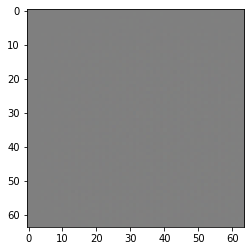

In [5]:
# use the untrained generator to generate an image
generator = make_generator_model()
noise = tf.random.normal([1,100])
generated_image = generator(noise, training=False)
print(generated_image.shape)
plt.imshow((generated_image.numpy()[0, :, :, :] * 127.5 + 127.5).astype(int))

In [6]:
# Discriminator
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(ndf, (5, 5), strides=(2, 2), padding='same', input_shape=[64, 64, nc]))
    model.add(layers.LeakyReLU())
    assert model.output_shape == (None, 32, 32, ndf)

    model.add(layers.Conv2D(ndf*2, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    assert model.output_shape == (None, 16, 16, ndf*2)

    model.add(layers.Conv2D(ndf*4, (5, 5), strides=(2, 2), padding='same'))
    print(model.output_shape)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    assert model.output_shape == (None, 8, 8, ndf*4)

    model.add(layers.Conv2D(ndf*8, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    assert model.output_shape == (None, 4, 4, ndf*8)
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [7]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

(None, 8, 8, 256)
tf.Tensor([[0.00019932]], shape=(1, 1), dtype=float32)


In [8]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [9]:
# Define losses
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1)

In [10]:
# Save checkpoints
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [11]:
# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_samples, nz])

In [12]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, nz])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        for step, image_batch in enumerate(dataset):
            step_time = time.time()
            gen_loss, disc_loss = train_step(image_batch)
            print("Epoch: [{}/{}] [{}] took: {:.3f}, d_loss: {:.5f}, g_loss: {:.5f}".format(epoch+1, \
                  epochs, step, time.time()-step_time, disc_loss, gen_loss))

        # Produce images for the GIF as we go
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    generate_and_save_images(generator,
                           epochs,
                           seed)

In [13]:
# Generate and save images
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(8,8))

    for i in range(predictions.shape[0]):
        plt.subplot(8, 8, i+1)
        plt.imshow((predictions.numpy()[i, :, :, :] * 127.5 + 127.5).astype(int)) # put image on [0,255] range
        plt.axis('off')

    plt.savefig(output_dir + '/' + 'image_at_epoch_{:04d}.png'.format(epoch))
    plt.clf()

In [14]:
# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir)).assert_consumed()

In [ ]:
# Train the model
train(train_dataset, epochs)

Epoch: [1/25] [0] took: 3.853, d_loss: 1.57716, g_loss: 0.48471
Epoch: [1/25] [1] took: 1.429, d_loss: 0.36023, g_loss: 2.17177
Epoch: [1/25] [2] took: 1.499, d_loss: 0.38480, g_loss: 1.57291
Epoch: [1/25] [3] took: 1.407, d_loss: 0.16187, g_loss: 2.72778
Epoch: [1/25] [4] took: 1.321, d_loss: 0.38996, g_loss: 1.94299
Epoch: [1/25] [5] took: 1.300, d_loss: 0.19281, g_loss: 2.92137
Epoch: [1/25] [6] took: 1.323, d_loss: 0.23169, g_loss: 2.36030
Epoch: [1/25] [7] took: 1.316, d_loss: 0.14394, g_loss: 3.14637
Epoch: [1/25] [8] took: 1.335, d_loss: 0.28043, g_loss: 1.94106
Epoch: [1/25] [9] took: 1.327, d_loss: 0.14867, g_loss: 5.08602
Epoch: [1/25] [10] took: 1.378, d_loss: 0.32111, g_loss: 1.54158
Epoch: [1/25] [11] took: 1.504, d_loss: 0.21251, g_loss: 7.87617
Epoch: [1/25] [12] took: 1.423, d_loss: 0.21621, g_loss: 4.76822
Epoch: [1/25] [13] took: 1.438, d_loss: 2.35402, g_loss: 0.14134
Epoch: [1/25] [14] took: 1.408, d_loss: 0.14748, g_loss: 17.59335
Epoch: [1/25] [15] took: 1.351, d_

Epoch: [1/25] [125] took: 1.283, d_loss: 0.34474, g_loss: 8.09205
Epoch: [1/25] [126] took: 1.279, d_loss: 0.13941, g_loss: 7.20679
Epoch: [1/25] [127] took: 1.262, d_loss: 0.08173, g_loss: 2.98814
Epoch: [1/25] [128] took: 1.266, d_loss: 0.42991, g_loss: 1.39993
Epoch: [1/25] [129] took: 1.303, d_loss: 0.24422, g_loss: 10.81064
Epoch: [1/25] [130] took: 1.263, d_loss: 0.31281, g_loss: 11.25290
Epoch: [1/25] [131] took: 1.277, d_loss: 0.10769, g_loss: 7.52450
Epoch: [1/25] [132] took: 1.260, d_loss: 0.29450, g_loss: 1.88942
Epoch: [1/25] [133] took: 1.293, d_loss: 0.18466, g_loss: 4.67874
Epoch: [1/25] [134] took: 1.278, d_loss: 0.29414, g_loss: 3.20439
Epoch: [1/25] [135] took: 1.288, d_loss: 0.32842, g_loss: 2.16565
Epoch: [1/25] [136] took: 1.264, d_loss: 0.24039, g_loss: 5.68755
Epoch: [1/25] [137] took: 1.291, d_loss: 0.03394, g_loss: 4.45743
Epoch: [1/25] [138] took: 1.297, d_loss: 0.36113, g_loss: 1.73199
Epoch: [1/25] [139] took: 1.247, d_loss: 0.19738, g_loss: 7.36194
Epoch: [

Epoch: [1/25] [249] took: 1.380, d_loss: 0.33662, g_loss: 12.59200
Epoch: [1/25] [250] took: 1.648, d_loss: 0.14279, g_loss: 4.93004
Epoch: [1/25] [251] took: 1.482, d_loss: 1.85446, g_loss: 0.20043
Epoch: [1/25] [252] took: 1.741, d_loss: 0.61792, g_loss: 18.52133
Epoch: [1/25] [253] took: 1.353, d_loss: 0.79432, g_loss: 21.81839
Epoch: [1/25] [254] took: 1.377, d_loss: 0.45603, g_loss: 19.70564
Epoch: [1/25] [255] took: 1.386, d_loss: 0.13843, g_loss: 16.21570
Epoch: [1/25] [256] took: 1.423, d_loss: 0.13922, g_loss: 12.30787
Epoch: [1/25] [257] took: 1.410, d_loss: 0.09408, g_loss: 8.08188
Epoch: [1/25] [258] took: 1.461, d_loss: 0.09686, g_loss: 2.84701
Epoch: [1/25] [259] took: 1.332, d_loss: 1.33921, g_loss: 0.36361
Epoch: [1/25] [260] took: 1.404, d_loss: 0.33514, g_loss: 14.97953
Epoch: [1/25] [261] took: 1.419, d_loss: 0.54268, g_loss: 18.40519
Epoch: [1/25] [262] took: 1.391, d_loss: 0.44896, g_loss: 16.82323
Epoch: [1/25] [263] took: 1.318, d_loss: 0.74124, g_loss: 12.81290


Epoch: [1/25] [373] took: 1.351, d_loss: 0.18871, g_loss: 3.22029
Epoch: [1/25] [374] took: 1.331, d_loss: 0.42308, g_loss: 1.35023
Epoch: [1/25] [375] took: 1.353, d_loss: 0.19149, g_loss: 8.11114
Epoch: [1/25] [376] took: 1.475, d_loss: 0.20662, g_loss: 8.27544
Epoch: [1/25] [377] took: 1.422, d_loss: 0.10212, g_loss: 5.02189
Epoch: [1/25] [378] took: 1.424, d_loss: 0.31952, g_loss: 1.58373
Epoch: [1/25] [379] took: 1.338, d_loss: 0.10300, g_loss: 6.11582
Epoch: [1/25] [380] took: 2.259, d_loss: 0.11831, g_loss: 6.08631
Epoch: [1/25] [381] took: 2.260, d_loss: 0.09991, g_loss: 3.96915
Epoch: [1/25] [382] took: 1.331, d_loss: 0.20387, g_loss: 1.94627
Epoch: [1/25] [383] took: 1.375, d_loss: 0.16074, g_loss: 5.58907
Epoch: [1/25] [384] took: 1.355, d_loss: 0.18216, g_loss: 5.34231
Epoch: [1/25] [385] took: 1.290, d_loss: 0.17907, g_loss: 2.57319
Epoch: [1/25] [386] took: 1.387, d_loss: 0.21010, g_loss: 2.56838
Epoch: [1/25] [387] took: 1.366, d_loss: 0.11151, g_loss: 3.68712
Epoch: [1/

Epoch: [1/25] [498] took: 1.359, d_loss: 0.32503, g_loss: 3.13088
Epoch: [1/25] [499] took: 1.455, d_loss: 1.09393, g_loss: 0.60234
Epoch: [1/25] [500] took: 1.434, d_loss: 2.25720, g_loss: 7.30726
Epoch: [1/25] [501] took: 1.380, d_loss: 0.65570, g_loss: 4.78348
Epoch: [1/25] [502] took: 1.322, d_loss: 1.95509, g_loss: 0.91913
Epoch: [1/25] [503] took: 1.355, d_loss: 1.20817, g_loss: 4.97596
Epoch: [1/25] [504] took: 1.530, d_loss: 0.48819, g_loss: 3.09284
Epoch: [1/25] [505] took: 1.389, d_loss: 0.41044, g_loss: 2.01734
Epoch: [1/25] [506] took: 1.309, d_loss: 0.28920, g_loss: 2.86595
Epoch: [1/25] [507] took: 1.371, d_loss: 0.54737, g_loss: 2.59646
Epoch: [1/25] [508] took: 1.423, d_loss: 0.39470, g_loss: 1.47293
Epoch: [1/25] [509] took: 1.366, d_loss: 0.75068, g_loss: 1.70418
Epoch: [1/25] [510] took: 1.319, d_loss: 0.72038, g_loss: 2.31560
Epoch: [1/25] [511] took: 1.386, d_loss: 0.74897, g_loss: 1.88936
Epoch: [1/25] [512] took: 1.376, d_loss: 0.83855, g_loss: 2.54468
Epoch: [1/

Epoch: [1/25] [623] took: 1.443, d_loss: 1.71565, g_loss: 0.46602
Epoch: [1/25] [624] took: 1.396, d_loss: 0.95871, g_loss: 7.38957
Epoch: [1/25] [625] took: 1.326, d_loss: 0.39587, g_loss: 5.31718
Epoch: [1/25] [626] took: 1.290, d_loss: 0.88126, g_loss: 1.04058
Epoch: [1/25] [627] took: 1.330, d_loss: 0.81635, g_loss: 2.50212
Epoch: [1/25] [628] took: 1.365, d_loss: 1.05228, g_loss: 1.24287
Epoch: [1/25] [629] took: 1.351, d_loss: 1.15373, g_loss: 1.65341
Epoch: [1/25] [630] took: 1.345, d_loss: 0.66030, g_loss: 2.81362
Epoch: [1/25] [631] took: 1.386, d_loss: 1.06842, g_loss: 0.95750
Epoch: [1/25] [632] took: 1.319, d_loss: 0.66504, g_loss: 4.58028
Epoch: [1/25] [633] took: 1.337, d_loss: 0.52957, g_loss: 1.58104
Epoch: [1/25] [634] took: 1.379, d_loss: 0.47625, g_loss: 2.07021
Epoch: [1/25] [635] took: 1.450, d_loss: 0.49006, g_loss: 2.19627
Epoch: [1/25] [636] took: 1.338, d_loss: 0.56501, g_loss: 1.37485
Epoch: [1/25] [637] took: 1.361, d_loss: 0.44560, g_loss: 3.50305
Epoch: [1/

Epoch: [1/25] [748] took: 1.398, d_loss: 0.53959, g_loss: 1.22329
Epoch: [1/25] [749] took: 1.383, d_loss: 0.37412, g_loss: 5.12156
Epoch: [1/25] [750] took: 1.408, d_loss: 0.24240, g_loss: 3.31986
Epoch: [1/25] [751] took: 1.650, d_loss: 0.57278, g_loss: 1.48513
Epoch: [1/25] [752] took: 1.382, d_loss: 0.44412, g_loss: 5.87455
Epoch: [1/25] [753] took: 1.409, d_loss: 0.52450, g_loss: 2.51863
Epoch: [1/25] [754] took: 1.392, d_loss: 0.64867, g_loss: 1.29481
Epoch: [1/25] [755] took: 1.370, d_loss: 0.68830, g_loss: 6.52962
Epoch: [1/25] [756] took: 1.434, d_loss: 0.28267, g_loss: 3.86389
Epoch: [1/25] [757] took: 1.394, d_loss: 0.86233, g_loss: 0.79156
Epoch: [1/25] [758] took: 1.330, d_loss: 0.63587, g_loss: 8.84010
Epoch: [1/25] [759] took: 1.375, d_loss: 0.27813, g_loss: 4.08165
Epoch: [1/25] [760] took: 1.354, d_loss: 1.32225, g_loss: 0.53822
Epoch: [1/25] [761] took: 1.329, d_loss: 1.98633, g_loss: 11.12560
Epoch: [1/25] [762] took: 1.356, d_loss: 0.14810, g_loss: 6.93295
Epoch: [1

Epoch: [1/25] [873] took: 1.323, d_loss: 0.59627, g_loss: 1.86398
Epoch: [1/25] [874] took: 1.397, d_loss: 0.32900, g_loss: 3.08757
Epoch: [1/25] [875] took: 1.382, d_loss: 0.31340, g_loss: 2.15374
Epoch: [1/25] [876] took: 1.364, d_loss: 0.19573, g_loss: 3.39649
Epoch: [1/25] [877] took: 1.482, d_loss: 0.16076, g_loss: 2.77443
Epoch: [1/25] [878] took: 1.435, d_loss: 0.23711, g_loss: 3.13947
Epoch: [1/25] [879] took: 1.398, d_loss: 0.40808, g_loss: 2.39797
Epoch: [1/25] [880] took: 1.341, d_loss: 0.23434, g_loss: 2.39223
Epoch: [1/25] [881] took: 1.442, d_loss: 0.40802, g_loss: 3.43881
Epoch: [1/25] [882] took: 1.408, d_loss: 0.94256, g_loss: 0.87020
Epoch: [1/25] [883] took: 1.385, d_loss: 0.67022, g_loss: 9.35240
Epoch: [1/25] [884] took: 1.406, d_loss: 0.58394, g_loss: 6.24935
Epoch: [1/25] [885] took: 1.392, d_loss: 1.68439, g_loss: 0.63785
Epoch: [1/25] [886] took: 1.490, d_loss: 0.37320, g_loss: 8.57295
Epoch: [1/25] [887] took: 1.393, d_loss: 0.28180, g_loss: 7.11198
Epoch: [1/

Epoch: [1/25] [998] took: 1.403, d_loss: 0.46398, g_loss: 6.37122
Epoch: [1/25] [999] took: 1.347, d_loss: 0.27094, g_loss: 3.00661
Epoch: [1/25] [1000] took: 1.363, d_loss: 0.79999, g_loss: 1.35482
Epoch: [1/25] [1001] took: 1.384, d_loss: 0.50878, g_loss: 3.74760
Epoch: [1/25] [1002] took: 1.397, d_loss: 0.41936, g_loss: 2.11038
Epoch: [1/25] [1003] took: 1.447, d_loss: 0.40786, g_loss: 2.53495
Epoch: [1/25] [1004] took: 1.426, d_loss: 0.43737, g_loss: 2.49640
Epoch: [1/25] [1005] took: 1.366, d_loss: 0.31390, g_loss: 2.45747
Epoch: [1/25] [1006] took: 1.368, d_loss: 0.59267, g_loss: 1.84135
Epoch: [1/25] [1007] took: 1.404, d_loss: 0.41610, g_loss: 3.00374
Epoch: [1/25] [1008] took: 1.347, d_loss: 0.46776, g_loss: 2.06318
Epoch: [1/25] [1009] took: 1.390, d_loss: 0.36336, g_loss: 2.11187
Epoch: [1/25] [1010] took: 1.354, d_loss: 0.15164, g_loss: 3.81457
Epoch: [1/25] [1011] took: 1.310, d_loss: 0.33217, g_loss: 3.18239
Epoch: [1/25] [1012] took: 1.400, d_loss: 0.62561, g_loss: 1.135

Epoch: [1/25] [1121] took: 1.364, d_loss: 0.38452, g_loss: 3.89075
Epoch: [1/25] [1122] took: 1.347, d_loss: 0.62199, g_loss: 2.08091
Epoch: [1/25] [1123] took: 1.354, d_loss: 0.62000, g_loss: 2.05048
Epoch: [1/25] [1124] took: 1.364, d_loss: 0.25731, g_loss: 2.48412
Epoch: [1/25] [1125] took: 1.413, d_loss: 0.41561, g_loss: 1.90152
Epoch: [1/25] [1126] took: 1.403, d_loss: 0.42637, g_loss: 2.47316
Epoch: [1/25] [1127] took: 1.356, d_loss: 0.69927, g_loss: 2.16121
Epoch: [1/25] [1128] took: 1.415, d_loss: 0.59074, g_loss: 1.43132
Epoch: [1/25] [1129] took: 1.567, d_loss: 0.47611, g_loss: 4.01264
Epoch: [1/25] [1130] took: 1.509, d_loss: 0.29842, g_loss: 2.63766
Epoch: [1/25] [1131] took: 1.367, d_loss: 0.45383, g_loss: 1.76175
Epoch: [1/25] [1132] took: 1.428, d_loss: 0.25700, g_loss: 4.44251
Epoch: [1/25] [1133] took: 1.336, d_loss: 0.17555, g_loss: 3.50627
Epoch: [1/25] [1134] took: 1.386, d_loss: 0.38084, g_loss: 1.89476
Epoch: [1/25] [1135] took: 1.332, d_loss: 0.31855, g_loss: 2.8

Epoch: [1/25] [1244] took: 1.339, d_loss: 0.28121, g_loss: 2.45456
Epoch: [1/25] [1245] took: 1.366, d_loss: 0.52303, g_loss: 1.94533
Epoch: [1/25] [1246] took: 1.359, d_loss: 0.31431, g_loss: 2.48627
Epoch: [1/25] [1247] took: 1.342, d_loss: 0.47902, g_loss: 2.72147
Epoch: [1/25] [1248] took: 1.352, d_loss: 0.57804, g_loss: 1.64242
Epoch: [1/25] [1249] took: 1.352, d_loss: 0.21689, g_loss: 4.51190
Epoch: [1/25] [1250] took: 1.322, d_loss: 0.32622, g_loss: 3.60167
Epoch: [1/25] [1251] took: 1.364, d_loss: 0.32645, g_loss: 1.93010
Epoch: [1/25] [1252] took: 1.354, d_loss: 0.15169, g_loss: 2.91013
Epoch: [1/25] [1253] took: 1.344, d_loss: 0.21702, g_loss: 3.55690
Epoch: [1/25] [1254] took: 1.371, d_loss: 0.68006, g_loss: 1.43549
Epoch: [1/25] [1255] took: 1.353, d_loss: 0.50990, g_loss: 4.75506
Epoch: [1/25] [1256] took: 1.345, d_loss: 0.44417, g_loss: 2.35783
Epoch: [1/25] [1257] took: 1.352, d_loss: 0.47651, g_loss: 1.64272
Epoch: [1/25] [1258] took: 1.387, d_loss: 0.43734, g_loss: 3.7

Epoch: [1/25] [1367] took: 1.452, d_loss: 0.17911, g_loss: 3.39869
Epoch: [1/25] [1368] took: 1.413, d_loss: 0.29935, g_loss: 2.23362
Epoch: [1/25] [1369] took: 1.426, d_loss: 0.32313, g_loss: 2.13138
Epoch: [1/25] [1370] took: 1.418, d_loss: 0.27445, g_loss: 2.86458
Epoch: [1/25] [1371] took: 1.381, d_loss: 0.43845, g_loss: 2.23815
Epoch: [1/25] [1372] took: 1.360, d_loss: 0.32852, g_loss: 2.59195
Epoch: [1/25] [1373] took: 1.430, d_loss: 0.32275, g_loss: 2.29154
Epoch: [1/25] [1374] took: 1.366, d_loss: 0.26411, g_loss: 3.24452
Epoch: [1/25] [1375] took: 1.372, d_loss: 0.26038, g_loss: 2.17862
Epoch: [1/25] [1376] took: 1.348, d_loss: 0.26716, g_loss: 3.49554
Epoch: [1/25] [1377] took: 1.372, d_loss: 0.27786, g_loss: 2.78498
Epoch: [1/25] [1378] took: 1.366, d_loss: 0.64826, g_loss: 1.81713
Epoch: [1/25] [1379] took: 1.333, d_loss: 0.31979, g_loss: 3.95495
Epoch: [1/25] [1380] took: 1.393, d_loss: 0.28689, g_loss: 2.63400
Epoch: [1/25] [1381] took: 1.327, d_loss: 0.46801, g_loss: 2.1

Epoch: [1/25] [1490] took: 1.259, d_loss: 0.51733, g_loss: 2.05001
Epoch: [1/25] [1491] took: 1.330, d_loss: 0.32611, g_loss: 2.73155
Epoch: [1/25] [1492] took: 1.271, d_loss: 0.36253, g_loss: 3.68559
Epoch: [1/25] [1493] took: 1.313, d_loss: 1.21896, g_loss: 0.82400
Epoch: [1/25] [1494] took: 1.269, d_loss: 1.98246, g_loss: 8.47997
Epoch: [1/25] [1495] took: 1.320, d_loss: 0.36729, g_loss: 3.36734
Epoch: [1/25] [1496] took: 1.288, d_loss: 1.11964, g_loss: 0.87167
Epoch: [1/25] [1497] took: 1.349, d_loss: 0.40414, g_loss: 7.57708
Epoch: [1/25] [1498] took: 1.298, d_loss: 0.86025, g_loss: 6.65825
Epoch: [1/25] [1499] took: 1.326, d_loss: 0.72921, g_loss: 1.26978
Epoch: [1/25] [1500] took: 1.321, d_loss: 0.30416, g_loss: 4.08309
Epoch: [1/25] [1501] took: 1.310, d_loss: 0.21478, g_loss: 4.70625
Epoch: [1/25] [1502] took: 1.271, d_loss: 0.34548, g_loss: 2.49242
Epoch: [1/25] [1503] took: 1.319, d_loss: 0.20397, g_loss: 3.09930
Epoch: [1/25] [1504] took: 1.299, d_loss: 0.32273, g_loss: 3.5

Epoch: [1/25] [1613] took: 1.377, d_loss: 0.14463, g_loss: 7.58177
Epoch: [1/25] [1614] took: 1.465, d_loss: 0.26260, g_loss: 6.09062
Epoch: [1/25] [1615] took: 1.505, d_loss: 0.49341, g_loss: 1.61075
Epoch: [1/25] [1616] took: 1.361, d_loss: 0.51865, g_loss: 4.15327
Epoch: [1/25] [1617] took: 1.415, d_loss: 0.46085, g_loss: 1.61409
Epoch: [1/25] [1618] took: 1.354, d_loss: 0.80415, g_loss: 5.11928
Epoch: [1/25] [1619] took: 1.374, d_loss: 0.65539, g_loss: 1.38619
Epoch: [1/25] [1620] took: 1.373, d_loss: 0.33337, g_loss: 4.69153
Epoch: [1/25] [1621] took: 1.382, d_loss: 0.25367, g_loss: 2.40314
Epoch: [1/25] [1622] took: 1.337, d_loss: 0.35138, g_loss: 3.48535
Epoch: [1/25] [1623] took: 1.350, d_loss: 0.40617, g_loss: 2.53111
Epoch: [1/25] [1624] took: 1.346, d_loss: 0.27912, g_loss: 2.31735
Epoch: [1/25] [1625] took: 1.444, d_loss: 0.21807, g_loss: 3.48165
Epoch: [1/25] [1626] took: 1.525, d_loss: 0.30153, g_loss: 2.80864
Epoch: [1/25] [1627] took: 1.386, d_loss: 0.56196, g_loss: 1.5

Epoch: [1/25] [1736] took: 1.444, d_loss: 0.32101, g_loss: 3.07946
Epoch: [1/25] [1737] took: 1.401, d_loss: 1.11201, g_loss: 1.02018
Epoch: [1/25] [1738] took: 1.425, d_loss: 2.06517, g_loss: 7.83252
Epoch: [1/25] [1739] took: 1.475, d_loss: 0.17343, g_loss: 2.71266
Epoch: [1/25] [1740] took: 1.433, d_loss: 0.76931, g_loss: 1.05454
Epoch: [1/25] [1741] took: 1.427, d_loss: 0.13792, g_loss: 7.59176
Epoch: [1/25] [1742] took: 1.547, d_loss: 0.38229, g_loss: 7.97847
Epoch: [1/25] [1743] took: 1.516, d_loss: 0.11740, g_loss: 4.20013
Epoch: [1/25] [1744] took: 1.514, d_loss: 0.54462, g_loss: 1.83146
Epoch: [1/25] [1745] took: 1.478, d_loss: 0.33901, g_loss: 2.80196
Epoch: [1/25] [1746] took: 1.462, d_loss: 0.35949, g_loss: 3.24232
Epoch: [1/25] [1747] took: 1.489, d_loss: 0.44008, g_loss: 2.45987
Epoch: [1/25] [1748] took: 1.434, d_loss: 0.61695, g_loss: 1.65784
Epoch: [1/25] [1749] took: 1.453, d_loss: 0.49941, g_loss: 4.49842
Epoch: [1/25] [1750] took: 1.403, d_loss: 0.39843, g_loss: 1.9

Epoch: [1/25] [1859] took: 1.585, d_loss: 0.42013, g_loss: 2.68659
Epoch: [1/25] [1860] took: 1.542, d_loss: 0.34048, g_loss: 3.53438
Epoch: [1/25] [1861] took: 1.505, d_loss: 0.40845, g_loss: 2.12087
Epoch: [1/25] [1862] took: 1.583, d_loss: 0.33912, g_loss: 2.53309
Epoch: [1/25] [1863] took: 1.533, d_loss: 0.47912, g_loss: 1.97460
Epoch: [1/25] [1864] took: 1.566, d_loss: 0.34913, g_loss: 4.96911
Epoch: [1/25] [1865] took: 1.503, d_loss: 0.32335, g_loss: 2.21972
Epoch: [1/25] [1866] took: 1.523, d_loss: 0.24980, g_loss: 2.82371
Epoch: [1/25] [1867] took: 1.551, d_loss: 0.46274, g_loss: 2.75139
Epoch: [1/25] [1868] took: 1.533, d_loss: 1.62288, g_loss: 0.41592
Epoch: [1/25] [1869] took: 1.530, d_loss: 4.68849, g_loss: 15.48365
Epoch: [1/25] [1870] took: 1.496, d_loss: 0.07597, g_loss: 6.95185
Epoch: [1/25] [1871] took: 1.573, d_loss: 1.36661, g_loss: 0.80052
Epoch: [1/25] [1872] took: 1.568, d_loss: 0.20835, g_loss: 4.54703
Epoch: [1/25] [1873] took: 1.496, d_loss: 0.28102, g_loss: 5.

Epoch: [1/25] [1982] took: 1.464, d_loss: 0.41297, g_loss: 2.17680
Epoch: [1/25] [1983] took: 1.588, d_loss: 0.32008, g_loss: 2.95176
Epoch: [1/25] [1984] took: 1.643, d_loss: 0.37741, g_loss: 1.92583
Epoch: [1/25] [1985] took: 1.580, d_loss: 0.23410, g_loss: 4.35030
Epoch: [1/25] [1986] took: 1.618, d_loss: 0.33523, g_loss: 2.35232
Epoch: [1/25] [1987] took: 1.567, d_loss: 0.37775, g_loss: 3.61800
Epoch: [1/25] [1988] took: 1.540, d_loss: 0.77258, g_loss: 1.07273
Epoch: [1/25] [1989] took: 1.556, d_loss: 0.52218, g_loss: 9.41011
Epoch: [1/25] [1990] took: 1.521, d_loss: 0.25888, g_loss: 7.10011
Epoch: [1/25] [1991] took: 1.619, d_loss: 0.41670, g_loss: 1.99889
Epoch: [1/25] [1992] took: 1.491, d_loss: 0.07566, g_loss: 5.05235
Epoch: [1/25] [1993] took: 1.502, d_loss: 0.22768, g_loss: 3.86431
Epoch: [1/25] [1994] took: 1.567, d_loss: 0.65048, g_loss: 1.53920
Epoch: [1/25] [1995] took: 1.489, d_loss: 0.71536, g_loss: 8.01240
Epoch: [1/25] [1996] took: 1.618, d_loss: 0.28088, g_loss: 4.1

Epoch: [1/25] [2105] took: 1.499, d_loss: 0.31218, g_loss: 1.75101
Epoch: [1/25] [2106] took: 1.462, d_loss: 0.38045, g_loss: 3.58432
Epoch: [1/25] [2107] took: 1.487, d_loss: 0.27678, g_loss: 3.74626
Epoch: [1/25] [2108] took: 1.517, d_loss: 0.60967, g_loss: 1.33043
Epoch: [1/25] [2109] took: 1.486, d_loss: 0.37596, g_loss: 5.20055
Epoch: [1/25] [2110] took: 1.483, d_loss: 0.15285, g_loss: 4.69538
Epoch: [1/25] [2111] took: 1.471, d_loss: 0.35323, g_loss: 1.89543
Epoch: [1/25] [2112] took: 1.516, d_loss: 0.36292, g_loss: 2.51313
Epoch: [1/25] [2113] took: 1.461, d_loss: 0.25149, g_loss: 2.44816
Epoch: [1/25] [2114] took: 1.487, d_loss: 0.36351, g_loss: 3.65767
Epoch: [1/25] [2115] took: 1.566, d_loss: 0.70133, g_loss: 1.35946
Epoch: [1/25] [2116] took: 1.561, d_loss: 0.72581, g_loss: 5.02924
Epoch: [1/25] [2117] took: 1.545, d_loss: 0.29900, g_loss: 2.21520
Epoch: [1/25] [2118] took: 1.544, d_loss: 0.52911, g_loss: 1.38256
Epoch: [1/25] [2119] took: 1.474, d_loss: 0.49530, g_loss: 6.3

Epoch: [1/25] [2228] took: 1.592, d_loss: 0.54105, g_loss: 5.70263
Epoch: [1/25] [2229] took: 1.499, d_loss: 0.22954, g_loss: 3.43029
Epoch: [1/25] [2230] took: 1.665, d_loss: 0.65999, g_loss: 1.37931
Epoch: [1/25] [2231] took: 1.480, d_loss: 0.55467, g_loss: 5.58617
Epoch: [1/25] [2232] took: 1.515, d_loss: 0.22023, g_loss: 2.55715
Epoch: [1/25] [2233] took: 1.524, d_loss: 0.38489, g_loss: 1.73778
Epoch: [1/25] [2234] took: 1.520, d_loss: 0.25130, g_loss: 5.62642
Epoch: [1/25] [2235] took: 1.563, d_loss: 0.31300, g_loss: 3.94968
Epoch: [1/25] [2236] took: 1.513, d_loss: 0.78734, g_loss: 1.00254
Epoch: [1/25] [2237] took: 1.537, d_loss: 0.61521, g_loss: 5.83048
Epoch: [1/25] [2238] took: 1.655, d_loss: 0.17783, g_loss: 3.43842
Epoch: [1/25] [2239] took: 1.500, d_loss: 0.63391, g_loss: 1.14420
Epoch: [1/25] [2240] took: 1.554, d_loss: 0.67536, g_loss: 6.62185
Epoch: [1/25] [2241] took: 1.576, d_loss: 0.18937, g_loss: 3.64251
Epoch: [1/25] [2242] took: 1.624, d_loss: 0.61478, g_loss: 1.0

Epoch: [1/25] [2351] took: 1.531, d_loss: 0.64941, g_loss: 1.60067
Epoch: [1/25] [2352] took: 1.522, d_loss: 0.39301, g_loss: 3.48861
Epoch: [1/25] [2353] took: 1.574, d_loss: 0.34397, g_loss: 2.67453
Epoch: [1/25] [2354] took: 1.518, d_loss: 0.45387, g_loss: 1.73903
Epoch: [1/25] [2355] took: 1.548, d_loss: 0.20079, g_loss: 2.98522
Epoch: [1/25] [2356] took: 1.567, d_loss: 0.20837, g_loss: 3.13382
Epoch: [1/25] [2357] took: 1.466, d_loss: 0.33640, g_loss: 2.35225
Epoch: [1/25] [2358] took: 1.553, d_loss: 0.36404, g_loss: 2.09043
Epoch: [1/25] [2359] took: 1.566, d_loss: 0.28143, g_loss: 3.57361
Epoch: [1/25] [2360] took: 1.546, d_loss: 0.32248, g_loss: 2.05322
Epoch: [1/25] [2361] took: 1.543, d_loss: 0.47303, g_loss: 3.03055
Epoch: [1/25] [2362] took: 1.493, d_loss: 0.77824, g_loss: 1.45860
Epoch: [1/25] [2363] took: 1.546, d_loss: 0.47723, g_loss: 3.21098
Epoch: [1/25] [2364] took: 1.580, d_loss: 0.48584, g_loss: 1.69515
Epoch: [1/25] [2365] took: 1.545, d_loss: 0.30501, g_loss: 2.5

Epoch: [1/25] [2474] took: 1.600, d_loss: 0.10376, g_loss: 3.77566
Epoch: [1/25] [2475] took: 1.492, d_loss: 0.38527, g_loss: 2.86518
Epoch: [1/25] [2476] took: 1.517, d_loss: 0.20718, g_loss: 2.33249
Epoch: [1/25] [2477] took: 1.619, d_loss: 0.25501, g_loss: 3.11766
Epoch: [1/25] [2478] took: 1.520, d_loss: 0.35661, g_loss: 1.83730
Epoch: [1/25] [2479] took: 1.648, d_loss: 0.38267, g_loss: 4.04188
Epoch: [1/25] [2480] took: 1.518, d_loss: 0.38475, g_loss: 1.93886
Epoch: [1/25] [2481] took: 1.453, d_loss: 0.16407, g_loss: 3.50632
Epoch: [1/25] [2482] took: 1.592, d_loss: 0.40328, g_loss: 3.49602
Epoch: [1/25] [2483] took: 1.518, d_loss: 0.45886, g_loss: 1.84121
Epoch: [1/25] [2484] took: 1.566, d_loss: 0.26109, g_loss: 4.41745
Epoch: [1/25] [2485] took: 1.613, d_loss: 0.15545, g_loss: 2.94478
Epoch: [1/25] [2486] took: 1.514, d_loss: 0.19961, g_loss: 2.96827
Epoch: [1/25] [2487] took: 1.595, d_loss: 0.22923, g_loss: 2.53299
Epoch: [1/25] [2488] took: 1.517, d_loss: 0.16161, g_loss: 2.9

Epoch: [1/25] [2597] took: 1.501, d_loss: 0.70009, g_loss: 1.73507
Epoch: [1/25] [2598] took: 1.518, d_loss: 0.77360, g_loss: 1.05957
Epoch: [1/25] [2599] took: 1.553, d_loss: 1.04735, g_loss: 6.56986
Epoch: [1/25] [2600] took: 1.585, d_loss: 0.18084, g_loss: 3.17624
Epoch: [1/25] [2601] took: 1.537, d_loss: 0.79126, g_loss: 0.88486
Epoch: [1/25] [2602] took: 1.518, d_loss: 0.40567, g_loss: 6.53318
Epoch: [1/25] [2603] took: 1.473, d_loss: 0.32525, g_loss: 6.00572
Epoch: [1/25] [2604] took: 1.562, d_loss: 0.24060, g_loss: 2.30303
Epoch: [1/25] [2605] took: 1.596, d_loss: 0.28754, g_loss: 2.19063
Epoch: [1/25] [2606] took: 1.657, d_loss: 0.27842, g_loss: 3.14742
Epoch: [1/25] [2607] took: 1.561, d_loss: 0.24103, g_loss: 2.64193
Epoch: [1/25] [2608] took: 1.499, d_loss: 0.44378, g_loss: 2.29084
Epoch: [1/25] [2609] took: 1.550, d_loss: 0.28855, g_loss: 3.63838
Epoch: [1/25] [2610] took: 1.595, d_loss: 0.54895, g_loss: 1.21508
Epoch: [1/25] [2611] took: 1.504, d_loss: 0.51925, g_loss: 6.2

Epoch: [1/25] [2720] took: 1.522, d_loss: 0.23236, g_loss: 3.13766
Epoch: [1/25] [2721] took: 1.468, d_loss: 0.36015, g_loss: 2.03913
Epoch: [1/25] [2722] took: 1.471, d_loss: 0.46367, g_loss: 3.26552
Epoch: [1/25] [2723] took: 1.507, d_loss: 0.31514, g_loss: 2.15450
Epoch: [1/25] [2724] took: 1.451, d_loss: 0.36331, g_loss: 3.69333
Epoch: [1/25] [2725] took: 1.511, d_loss: 0.30726, g_loss: 2.36386
Epoch: [1/25] [2726] took: 1.510, d_loss: 0.29311, g_loss: 2.91343
Epoch: [1/25] [2727] took: 1.468, d_loss: 0.41849, g_loss: 2.50260
Epoch: [1/25] [2728] took: 1.524, d_loss: 0.49076, g_loss: 2.13276
Epoch: [1/25] [2729] took: 1.480, d_loss: 0.37272, g_loss: 2.27326
Epoch: [1/25] [2730] took: 1.452, d_loss: 0.31989, g_loss: 3.67047
Epoch: [1/25] [2731] took: 1.579, d_loss: 0.32647, g_loss: 2.73667
Epoch: [1/25] [2732] took: 1.570, d_loss: 0.28568, g_loss: 2.01670
Epoch: [1/25] [2733] took: 1.561, d_loss: 0.30326, g_loss: 3.58025
Epoch: [1/25] [2734] took: 1.562, d_loss: 0.24924, g_loss: 2.5

Epoch: [1/25] [2843] took: 1.497, d_loss: 0.20507, g_loss: 3.29560
Epoch: [1/25] [2844] took: 1.462, d_loss: 0.35789, g_loss: 2.36403
Epoch: [1/25] [2845] took: 1.496, d_loss: 0.36003, g_loss: 2.37752
Epoch: [1/25] [2846] took: 1.455, d_loss: 0.35264, g_loss: 2.73756
Epoch: [1/25] [2847] took: 1.519, d_loss: 0.36392, g_loss: 2.38581
Epoch: [1/25] [2848] took: 1.534, d_loss: 0.21685, g_loss: 2.71611
Epoch: [1/25] [2849] took: 1.537, d_loss: 0.23289, g_loss: 2.79707
Epoch: [1/25] [2850] took: 1.654, d_loss: 0.47693, g_loss: 2.27475
Epoch: [1/25] [2851] took: 1.549, d_loss: 0.48538, g_loss: 1.63093
Epoch: [1/25] [2852] took: 1.559, d_loss: 0.55394, g_loss: 4.51747
Epoch: [1/25] [2853] took: 1.575, d_loss: 0.26241, g_loss: 2.21217
Epoch: [1/25] [2854] took: 1.580, d_loss: 0.32741, g_loss: 1.72932
Epoch: [1/25] [2855] took: 1.637, d_loss: 0.26983, g_loss: 4.41098
Epoch: [1/25] [2856] took: 1.528, d_loss: 0.15195, g_loss: 3.47614
Epoch: [1/25] [2857] took: 1.573, d_loss: 0.28638, g_loss: 2.3

Epoch: [1/25] [2966] took: 1.807, d_loss: 0.30461, g_loss: 4.00927
Epoch: [1/25] [2967] took: 1.857, d_loss: 0.22364, g_loss: 3.16467
Epoch: [1/25] [2968] took: 1.774, d_loss: 0.51991, g_loss: 1.38355
Epoch: [1/25] [2969] took: 1.635, d_loss: 0.34545, g_loss: 4.85951
Epoch: [1/25] [2970] took: 1.691, d_loss: 0.63870, g_loss: 3.53454
Epoch: [1/25] [2971] took: 1.542, d_loss: 0.99283, g_loss: 0.85618
Epoch: [1/25] [2972] took: 1.559, d_loss: 0.28258, g_loss: 5.59262
Epoch: [1/25] [2973] took: 1.538, d_loss: 0.21809, g_loss: 5.62387
Epoch: [1/25] [2974] took: 1.470, d_loss: 0.31036, g_loss: 2.69978
Epoch: [1/25] [2975] took: 1.535, d_loss: 0.44149, g_loss: 1.75641
Epoch: [1/25] [2976] took: 1.481, d_loss: 0.28825, g_loss: 3.98208
Epoch: [1/25] [2977] took: 1.550, d_loss: 0.37866, g_loss: 2.52799
Epoch: [1/25] [2978] took: 1.630, d_loss: 0.43367, g_loss: 2.21769
Epoch: [1/25] [2979] took: 1.579, d_loss: 0.43034, g_loss: 2.30812
Epoch: [1/25] [2980] took: 1.655, d_loss: 0.40639, g_loss: 1.9

Epoch: [1/25] [3089] took: 1.484, d_loss: 0.74971, g_loss: 9.80690
Epoch: [1/25] [3090] took: 1.510, d_loss: 0.50031, g_loss: 7.34181
Epoch: [1/25] [3091] took: 1.457, d_loss: 0.29186, g_loss: 2.19485
Epoch: [1/25] [3092] took: 1.472, d_loss: 0.38131, g_loss: 1.77378
Epoch: [1/25] [3093] took: 1.512, d_loss: 1.75716, g_loss: 5.35449
Epoch: [1/25] [3094] took: 1.470, d_loss: 1.44212, g_loss: 0.60536
Epoch: [1/25] [3095] took: 1.501, d_loss: 0.09496, g_loss: 6.95229
Epoch: [1/25] [3096] took: 1.462, d_loss: 0.28742, g_loss: 8.41986
Epoch: [1/25] [3097] took: 1.440, d_loss: 0.20679, g_loss: 4.56818
Epoch: [1/25] [3098] took: 1.455, d_loss: 0.51524, g_loss: 1.56377
Epoch: [1/25] [3099] took: 1.445, d_loss: 0.19526, g_loss: 4.58852
Epoch: [1/25] [3100] took: 1.425, d_loss: 0.34890, g_loss: 4.17134
Epoch: [1/25] [3101] took: 1.451, d_loss: 0.61585, g_loss: 1.20796
Epoch: [1/25] [3102] took: 1.512, d_loss: 0.49325, g_loss: 3.74211
Epoch: [1/25] [3103] took: 1.487, d_loss: 0.36557, g_loss: 2.3